In [1]:
import pandas as pd
from pprint import pprint
import numpy as np
import json
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sn
import matplotlib.ticker as mticker

# Load dataset
data = pd.read_json("dataset.35past.Linux10k.json")

In [6]:
## RQ3

pd.options.mode.chained_assignment = None

print(np.__version__)
tests = data.drop_duplicates(subset=['buildId', 'testId'])

# Count total flaky and failing
flaky = tests[tests["label"] == 0]
failing = tests[tests["label"] == 1]

# Count both flaky and failing
# Group by 'testId' and calculate the number of unique 'label' values
tests['label_count'] = tests.groupby('testId')['label'].transform('nunique')

# Filter rows where 'label_count' is greater than 1, indicating different labels for the same 'testId'
result = tests[tests['label_count'] > 1]

# Drop the 'label_count' column if you don't need it
result = result.drop(columns='label_count')


print("Number of Flaky Tests", flaky["testId"].nunique())
print("Number of Failing Tests", failing["testId"].nunique())
print("Number of Flaky AND Failing Tests", result["testId"].nunique())

1.19.5
Number of Flaky Tests 23374
Number of Failing Tests 2343
Number of Flaky AND Failing Tests 897


In [22]:
from tqdm import tqdm

tests = data.drop_duplicates(subset=['buildId', 'testId'])

flaky = tests[tests["label"] == 0]
failing = tests[tests["label"] == 1]

uFlaky = flaky["testId"].unique()
uFailing = failing["testId"].unique()

print(flaky["testId"].nunique())
print(failing["testId"].nunique())

def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3

inter = intersection(uFlaky, uFailing)
print("Number of tests being both flaky and fault-revealing:", len(inter))

scatterData = pd.DataFrame()
for el in tqdm(inter):
    countFailing = (failing["testId"] == el).sum()
    countFlaky = (flaky["testId"] == el).sum()
    dic = {"testId": el, "nbFailing": countFailing, "nbFlaky": countFlaky}
    scatterData = scatterData.append(dic, ignore_index = True)
print(scatterData.describe())

18095
1276
Number of tests being both flaky and fault-revealing: 645


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 645/645 [01:13<00:00,  8.81it/s]

        nbFailing      nbFlaky
count  645.000000   645.000000
mean     3.618605   511.609302
std      6.191832  1034.475616
min      1.000000     1.000000
25%      1.000000    28.000000
50%      1.000000   166.000000
75%      4.000000   555.000000
max     83.000000  8642.000000


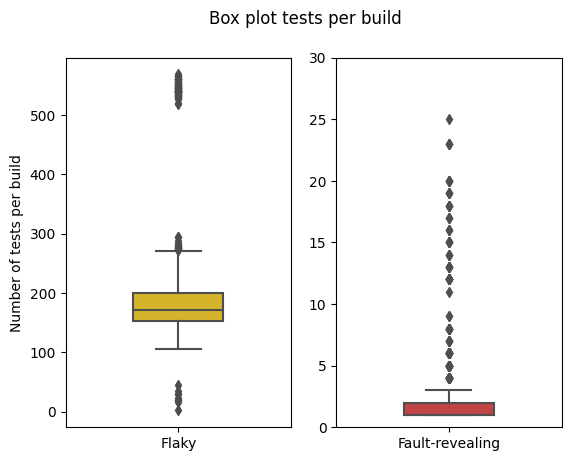

In [19]:
# plt.figure(figsize=(15,4))
fig, ax = plt.subplots(1, 2)
fig.suptitle('Box plot tests per build')

sn.boxplot(data=countFlaky, x="label", y="Number of tests per build", width=0.4, palette=["#f1c40f"], ax=ax[0])
sn.boxplot(data=countFailing, x="label", y="Number of tests per build", width=0.4, palette=["#d63031"], ax=ax[1])
ax[0].set(xlabel=None)
ax[1].set(xlabel=None)
ax[1].set(ylabel=None)

# Show plot
plt.ylim(0, 30)
plt.savefig('sample.png', dpi=150, bbox_inches='tight')
plt.show()

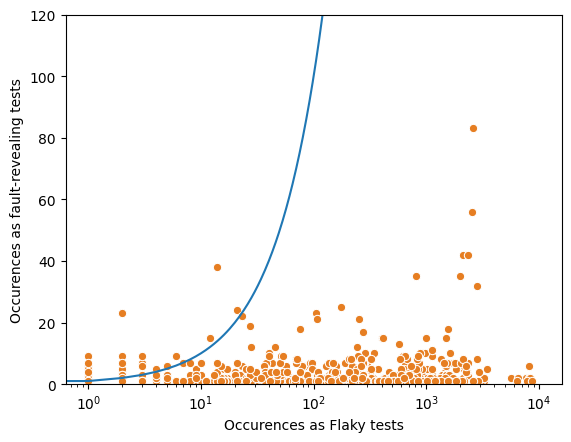

The number of points under the line x=y is: 612


In [23]:
## Discussion
# Scatter plot for Occurence failing / flaky in overlap entire dataset

ax = sn.scatterplot(data=scatterData, y="nbFailing", x="nbFlaky", color=["#e67e22"])
ax.set(xlabel='Occurences as Flaky tests', ylabel='Occurences as fault-revealing tests')
ax.set_xscale('log')

# Plot the line y = x
x = range(0, 10000)
y = x
plt.plot(x, y)
ax.set_ylim(0, 120)

plt.savefig('scatterPlot.png', dpi=150, bbox_inches='tight')
plt.show()

# Count points under the line x=y
count = 0
for i in range(len(scatterData)):
    if scatterData["nbFailing"][i] <= scatterData["nbFlaky"][i]:
        count += 1

# Display the count
print(f"The number of points under the line x=y is: {count}")

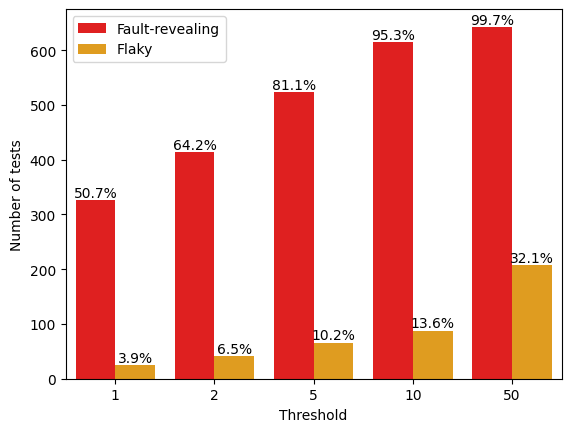

In [24]:
# Histogram
thresholds = [1, 2, 5, 10, 50]  # Thresholds to consider

# Calculate the total number of elements in the DataFrame
total_elements = len(scatterData)

# Calculate the number of elements above each threshold for each column
above_thresholds_failing = [sum(scatterData["nbFailing"] <= threshold) for threshold in thresholds]
above_thresholds_flaky = [sum(scatterData["nbFlaky"] <= threshold) for threshold in thresholds]

# pprint(data.head())

# Create a DataFrame with the threshold and count information
data = pd.DataFrame({'Threshold': thresholds, 'Fault-revealing': above_thresholds_failing, 
                     'Flaky': above_thresholds_flaky})

# Combine the data for fault-revealing and flaky tests into a single DataFrame
combined_data = pd.melt(data, id_vars=['Threshold'], var_name='Test Type', value_name='Number of tests')

# Create the histogram plot using seaborn
ax = sn.barplot(data=combined_data, x='Threshold', y='Number of tests', hue='Test Type', palette=["red", "orange"])

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[2:], labels=labels[2:])

# Add percentage labels to the bars
for bar in ax.containers:
    for rect in bar:
        height = rect.get_height()
        percentage = (height / total_elements) * 100
        ax.text(rect.get_x() + rect.get_width() / 2, height, f'{percentage:.1f}%', ha='center', va='bottom')

In [25]:
# Requires seaborn 0.11
# print(sn.__version__)

# tests.rename(columns={'flakeRate':'Flake rate'}, inplace=True)
# tests.label = tests.label.replace(0, "Flaky tests")
# tests.label = tests.label.replace(1, "Fault-revealing tests")

# p = sn.kdeplot(data=tests, x="Flake rate", hue="label", palette=['red',"orange"], common_norm=False, shade=True, fill=True)
# lss = [':', '--']

# handles = p.legend_.legendHandles[::-1]

# for line, ls, handle in zip(p.collections, lss, handles):
#     line.set_linestyle(ls)
#     handle.set_ls(ls)
# plt.show()